# **Predict Sale Price**

## Objectives

*  Train an ML pipeline using hyperparameter optimization with the best features to predict a property's sale price.

## Tasks
* Loading Data
* Creating the ML Regressor Pipelines
* Split Train and Test sets
* Grid Search CV - Sklearn

## Inputs

* outputs/datasets/cleaned/clean_house_price_records.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Feature Importance Plot

## Additional Comments

* This notebook was written based on the guidelines provided in the Customer Churn walk through project, Predict Churn lesson.
* This notebook relates to the Modelling step of Crisp-DM methodology

---

# Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housing-sales-price-prediction-dashboard/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/housing-sales-price-prediction-dashboard'

---

# Import Packages & set environment variables

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

---

# Load House Price Records

Read the house_prices_records dataset csv file into a Pandas dataframe

In [5]:
df = pd.read_csv(f"outputs/datasets/cleaned/clean_house_price_records.csv")
print(df.shape)
df.head()

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,1710,Gd,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,1262,TA,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,1786,Gd,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,0.0,No,216,ALQ,540,642,Unf,1998.0,1717,Gd,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,2198,Gd,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

## ML Regressor Pipeline

* Create ML pipeline for Data Cleaning and Feature Engineering

In [6]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
selection_method="cardinality"
corr_method = "spearman"
def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['BsmtExposure', 
                                                               'BsmtFinType1', 
                                                               'GarageFinish', 
                                                               'KitchenQual'] )),      
      
      ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea'])),
      ("NumericPowerTransform",vt.PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
      ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method=corr_method, 
                                                           threshold=0.6, selection_method=selection_method
                                                           )),
      
      ("feat_scaling", StandardScaler() ),

      ("feat_selection",  SelectFromModel(model) ),

      ("model", model ),
       
    ])

  return pipeline_base

## Hyperparameter Optimisation

* Custom Class for hyperparameter Optimization

In [7]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


---

## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimization search using default hyperparameters

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.701151,0.796894,0.844134,0.055717
3,ExtraTreesRegressor,0.673918,0.795043,0.854726,0.070255
5,GradientBoostingRegressor,0.607884,0.777045,0.841748,0.087251
6,XGBRegressor,0.657233,0.746683,0.797773,0.047551
0,LinearRegression,0.639004,0.735226,0.802878,0.056704
4,AdaBoostRegressor,0.614958,0.721632,0.771453,0.055037
1,DecisionTreeRegressor,0.311062,0.551606,0.648556,0.12305


* Client business requirement is an R2 score of at least 0.75
* The best result is RandomForestRegressor with an average R2 score around 0.80
* Applying an extensive search may improve the score

---

## Extensive Search

* Do extensive search on most suitable model to find best hyperparameter configuration

### Define model and parameters, for Extensive Search

In [12]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [100,700],
        'model__max_depth': [6,18,None],
    }
}

Extensive GridSearch CV

In [13]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
2,RandomForestRegressor,0.701858,0.798361,0.8445,0.054502,18,100
3,RandomForestRegressor,0.694209,0.797251,0.848445,0.059185,18,700
4,RandomForestRegressor,0.701151,0.796894,0.844134,0.055717,None,100
5,RandomForestRegressor,0.692895,0.796777,0.848255,0.059509,None,700
0,RandomForestRegressor,0.684057,0.788087,0.841819,0.06024,6,100
1,RandomForestRegressor,0.681159,0.785992,0.839809,0.062342,6,700


* An extensive search improved the score, but only slightly
* Nevertheless, the client business requirement of 0.75 has been met with a score of 0.80

---

Find the best model

In [15]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

In [16]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 18, 'model__n_estimators': 100}

Define the best regressor, based on search

In [17]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'LotArea',
                                           'GrLivArea'])),
                ('NumericPowerTransform',
                 PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
                ('NumericYeoJohnsonTra...
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                    

Parameters for best model

---

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['GrLivArea', 'GarageArea', 'YearBuilt', '1stFlrSF']


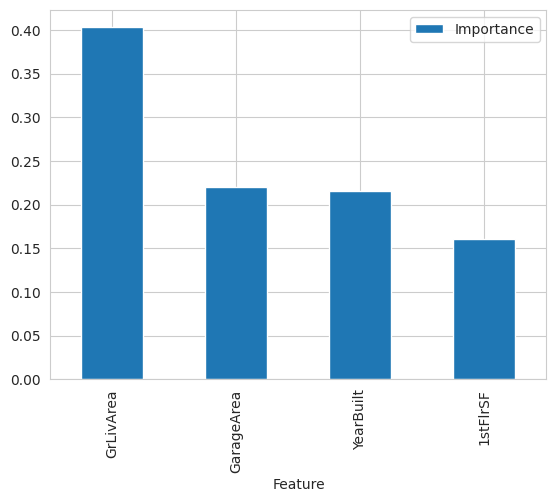

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 5 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

---

## Evaluate Pipeline Performance

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Evaluate Performance on Train and Test sets

Model Evaluation 

* Train Set
R2 Score: 0.97
Mean Absolute Error: 8537.609
Mean Squared Error: 187076774.089
Root Mean Squared Error: 13677.601


* Test Set
R2 Score: 0.784
Mean Absolute Error: 24141.431
Mean Squared Error: 1494726623.124
Root Mean Squared Error: 38661.695




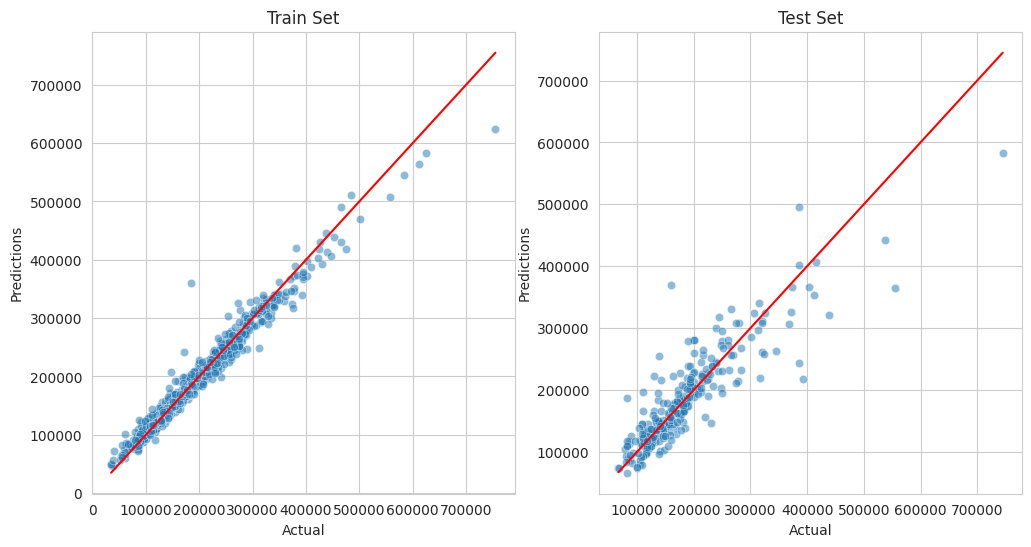

In [20]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Applying Regressor with PCA

Explore potential values for PCA n_components.

In [21]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:6])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 17 components explain 100.0% of the data 



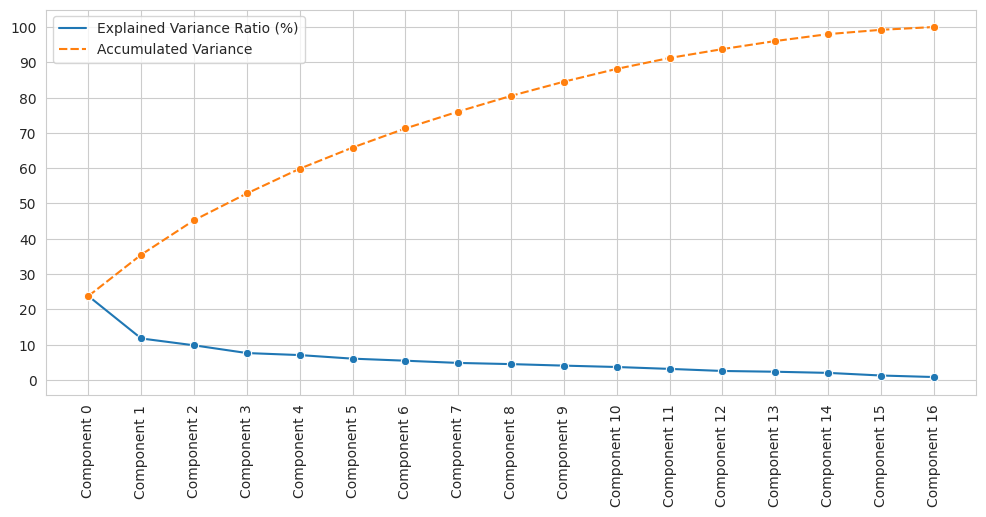

In [22]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)

* The 9 components explain 80.49% of the data 



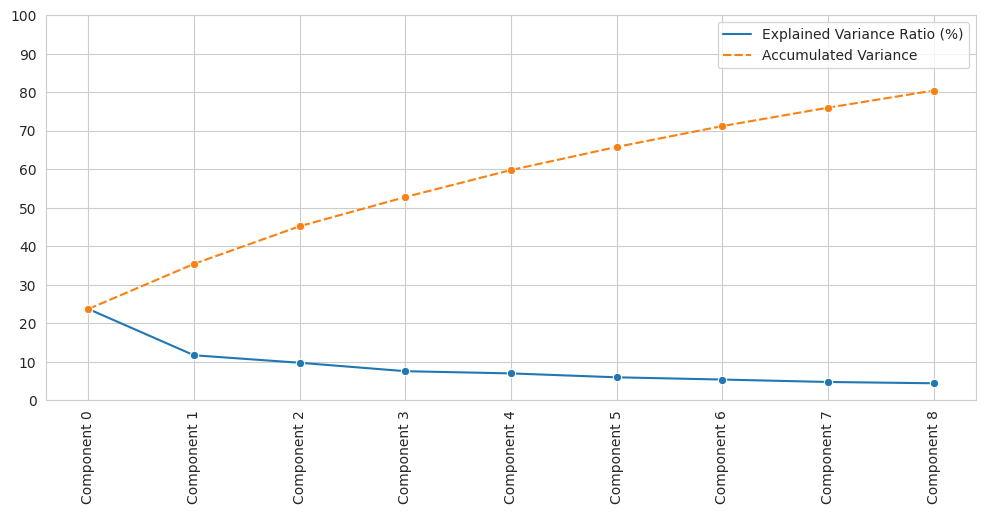

In [23]:
n_components = 9
pca_components_analysis(df_pca=df_pca,n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [24]:
from sklearn.decomposition import PCA

selection_method="cardinality"
corr_method = "spearman"
n_components = 9


def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['BsmtExposure', 
                                                               'BsmtFinType1', 
                                                               'GarageFinish', 
                                                               'KitchenQual'] )),      
      
      ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea'])),
      ("NumericPowerTransform",vt.PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
      ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),

      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method=corr_method, 
                                                           threshold=0.6, selection_method=selection_method
                                                           )),
      
      ("feat_scaling", StandardScaler() ),

      ("PCA", PCA(n_components=n_components, random_state=0)),

      ("model", model ),
       
    ])

  return pipeline_base

## Grid Search CV – Sklearn

In [25]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Use standard hyperparameters to find most suitable model

In [26]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a quick optimization search 

In [27]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [28]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.729657,0.786499,0.821848,0.031637
5,GradientBoostingRegressor,0.712058,0.782249,0.816912,0.036346
3,ExtraTreesRegressor,0.651892,0.768458,0.824174,0.062635
6,XGBRegressor,0.675336,0.754652,0.789408,0.044909
4,AdaBoostRegressor,0.688372,0.742515,0.768837,0.029308
0,LinearRegression,0.648534,0.724851,0.792781,0.047302
1,DecisionTreeRegressor,0.478543,0.610167,0.651408,0.066089


### Do extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters for extensive search

In [29]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [100,700],
        'model__max_depth': [6,18,None],
    }
}

Extensive GridSearch CV

In [30]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [31]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
2,RandomForestRegressor,0.73474,0.787408,0.827112,0.031191,18,100
4,RandomForestRegressor,0.729657,0.786499,0.821848,0.031637,None,100
5,RandomForestRegressor,0.731361,0.78571,0.829403,0.033222,None,700
3,RandomForestRegressor,0.729946,0.785168,0.831081,0.034152,18,700
0,RandomForestRegressor,0.724691,0.780085,0.819108,0.032099,6,100
1,RandomForestRegressor,0.721957,0.778939,0.824745,0.034888,6,700


Check the best model

In [32]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Parameters for best model

In [33]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 18, 'model__n_estimators': 100}

Define the best regressor

In [34]:
best_regressor_pipeline_pca = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline_pca

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'LotArea',
                                           'GrLivArea'])),
                ('NumericPowerTransform',
                 PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
                ('NumericYeoJohnsonTra...
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                      

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.967
Mean Absolute Error: 8811.979
Mean Squared Error: 201079086.949
Root Mean Squared Error: 14180.236


* Test Set
R2 Score: 0.745
Mean Absolute Error: 23671.175
Mean Squared Error: 1758837775.264
Root Mean Squared Error: 41938.5




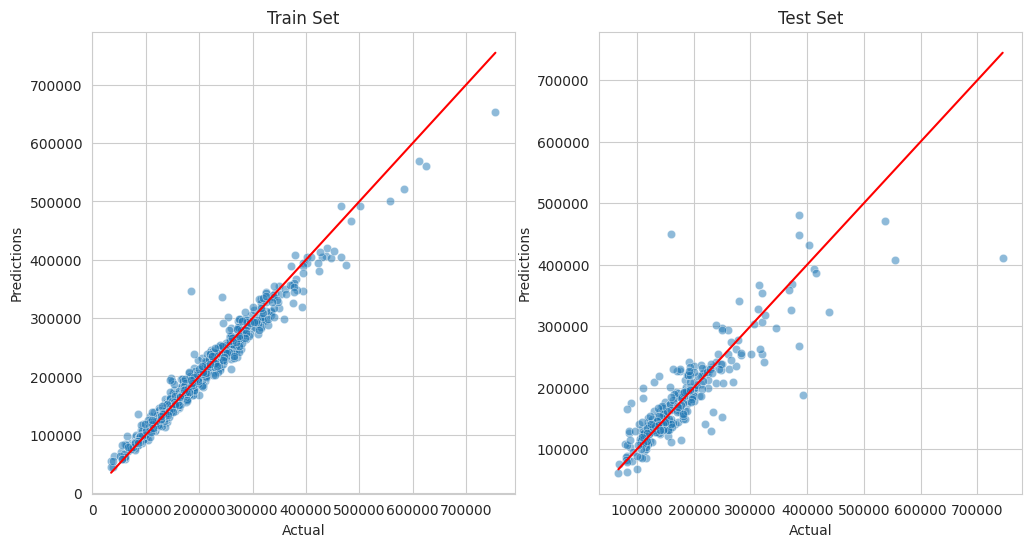

In [35]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline_pca)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline_pca)

---

# Conclusion

* A Regressor model was chosen to predict sale price for a given property.
* Both feature selection and PCA produced similar results and met business requirement 1. By a small margin, feature selection performed better. Therefore, the best pipeline to use will be that of feature selection. 
* Feature selection achieved an R2 Score: 0.97 on the train set and an R2 Score: 0.78 on the test set.
* The client requirement is for an R2 Score of 0.75\n"

---


# Save datasets and models 

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* features importance plot

In [36]:
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_saleprice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_saleprice/v1'


## Train Set : features and target

In [37]:
print(X_train.shape)
X_train.head()

(1168, 21)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0.0,0.0,Av,48,Unk,1774,774,Unf,2007.0,1828,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007
870,894,0.0,2.0,No,0,Unf,894,308,Unf,1962.0,894,TA,6600,60.0,0.0,0,5,5,894,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,964,TA,13360,80.0,0.0,0,7,5,876,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,1689,Gd,13265,69.0,148.0,59,5,8,1568,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,1541,Gd,13704,118.0,150.0,81,5,7,1541,2001,2002


In [38]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [39]:
print(y_train.shape)
y_train.head()

(1168,)


618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [40]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [41]:
print(X_test.shape)
X_test.head()

(292, 21)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
529,2515,0.0,4.0,No,1219,Rec,816,484,Unf,1975.0,2515,TA,32668,69.0,0.0,0,3,6,2035,1957,1975
491,958,620.0,3.0,No,403,BLQ,238,240,Unf,1941.0,1578,Fa,9490,79.0,0.0,0,7,6,806,1941,1950
459,979,224.0,3.0,No,185,LwQ,524,352,Unf,1950.0,1203,Gd,7015,69.0,161.0,0,4,5,709,1950,1950
279,1156,866.0,4.0,No,392,BLQ,768,505,Fin,1977.0,2022,TA,10005,83.0,299.0,117,5,7,1160,1977,1977
655,525,0.0,3.0,No,0,Unf,525,264,Unf,1971.0,1092,TA,1680,21.0,381.0,0,5,6,525,1971,1971


In [42]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [43]:
print(y_test.shape)
y_test.head()

(292,)


529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [44]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [45]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'LotArea',
                                           'GrLivArea'])),
                ('NumericPowerTransform',
                 PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
                ('NumericYeoJohnsonTra...
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                    

In [46]:
import joblib
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_saleprice/v1/best_regressor_pipeline.pkl']

In [47]:
df_feature_importance.to_csv(f"{file_path}/feature_importance.csv", index=False)

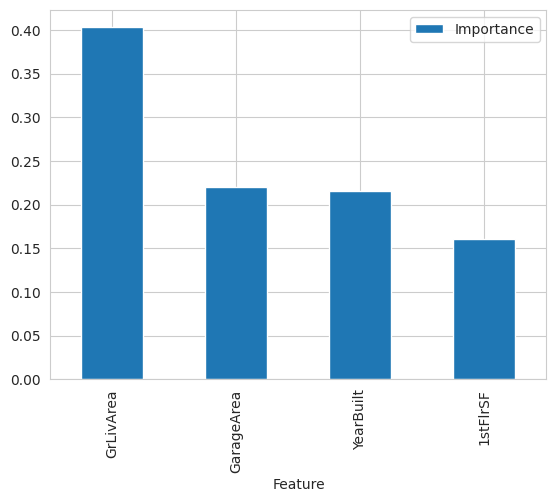

In [48]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')

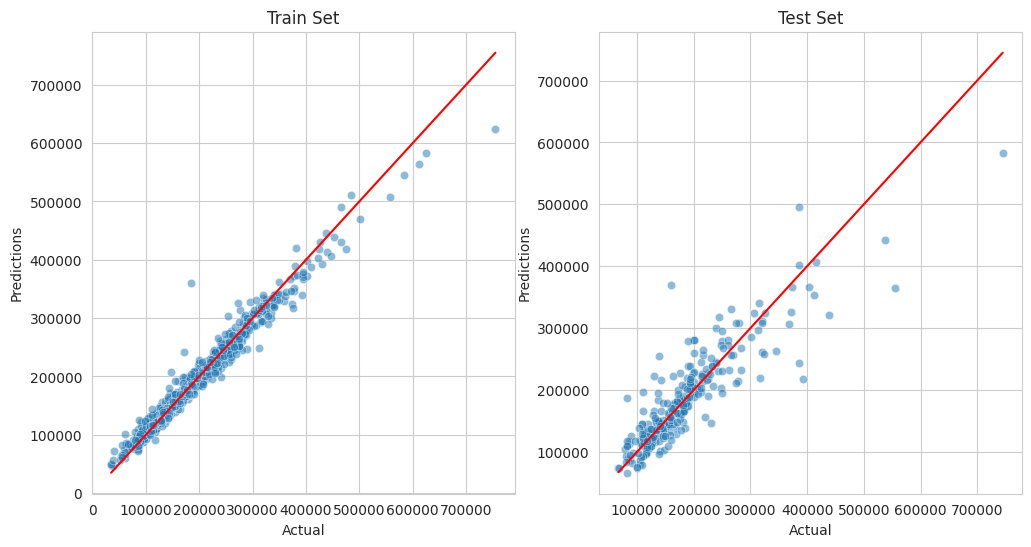

In [49]:
# regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)
pred_train = best_regressor_pipeline.predict(X_train)
pred_test = best_regressor_pipeline.predict(X_test)
alpha_scatter=0.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.savefig(f'{file_path}/regression_evaluation_plots.png', bbox_inches='tight')

---